<IPython.core.display.Javascript object>


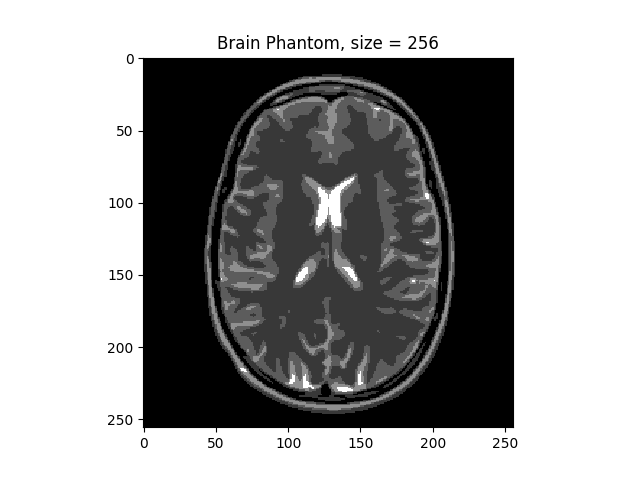

In [41]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters
#get current working dir
cwd = os.getcwd()
#cwd= "/"
dirimg_2d = op.join(cwd,"data")
img_size = 256   #256
FOV = 0.2 #field of view in meters
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

<IPython.core.display.Javascript object>


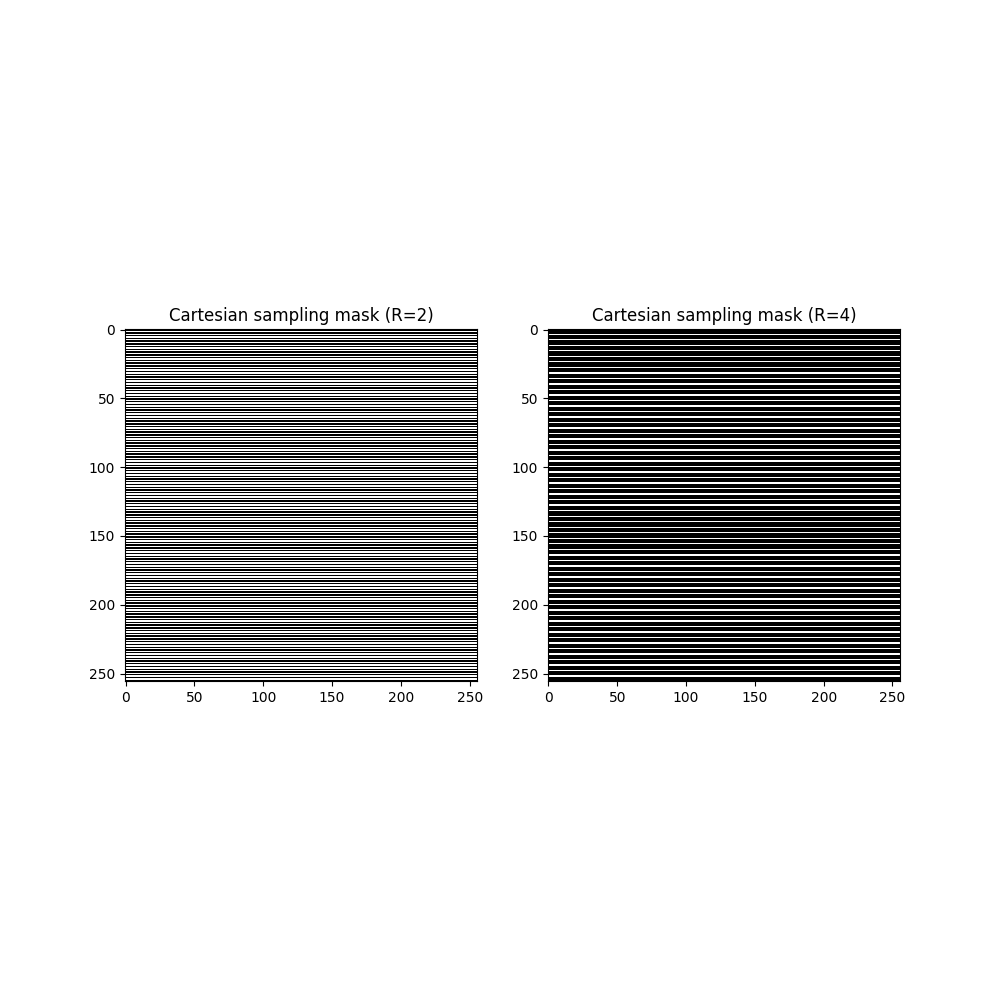

Text(0.5, 1.0, 'Cartesian sampling mask (R=4)')

In [42]:
import numpy as np
from scipy.io import loadmat
#import pdb
#pdb.set_trace()

#img_size = 512
type(img_size)
# generate Cartesian lines in a straightforward manner
#a = np.linspace(0,img_size,img_size)
a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
 
#b = np.linspace(0,img_size,img_size)
#b = np.linspace(1,img_size,img_size)-1
import numpy.matlib as mlib
#B = mlib.repmat(b,img_size,1)
#c = np.ones((img_size,img_size),dtype="int")

c = np.ones((1, img_size), dtype="float64")
c.shape
d = np.zeros((1, img_size), dtype="float64")
d.shape
comb2 = np.concatenate((c,d), axis=0)
comb4 = np.concatenate((c,d,d,d), axis=0)
r2 = (int)(img_size/2)
r4 = (int)(img_size/4)

#import numpy.matlib as mlib
#uniform density
#kspace_mask_r2 = mlib.repmat(comb2, img_size/2, 1)
#kspace_mask_r4 = mlib.repmat(comb4, img_size/4, 1)
kspace_mask_r2 = np.tile(comb2, (r2, 1))
kspace_mask_r4 = np.tile(comb4, (r4, 1))


fig, axs = plt.subplots(1, 2, figsize=(10, 10) )
axs[0].imshow(kspace_mask_r2, cmap='Greys_r')
axs[0].set_title("Cartesian sampling mask (R=2)")
axs[1].imshow(kspace_mask_r4, cmap='Greys_r')
axs[1].set_title("Cartesian sampling mask (R=4)")


<IPython.core.display.Javascript object>


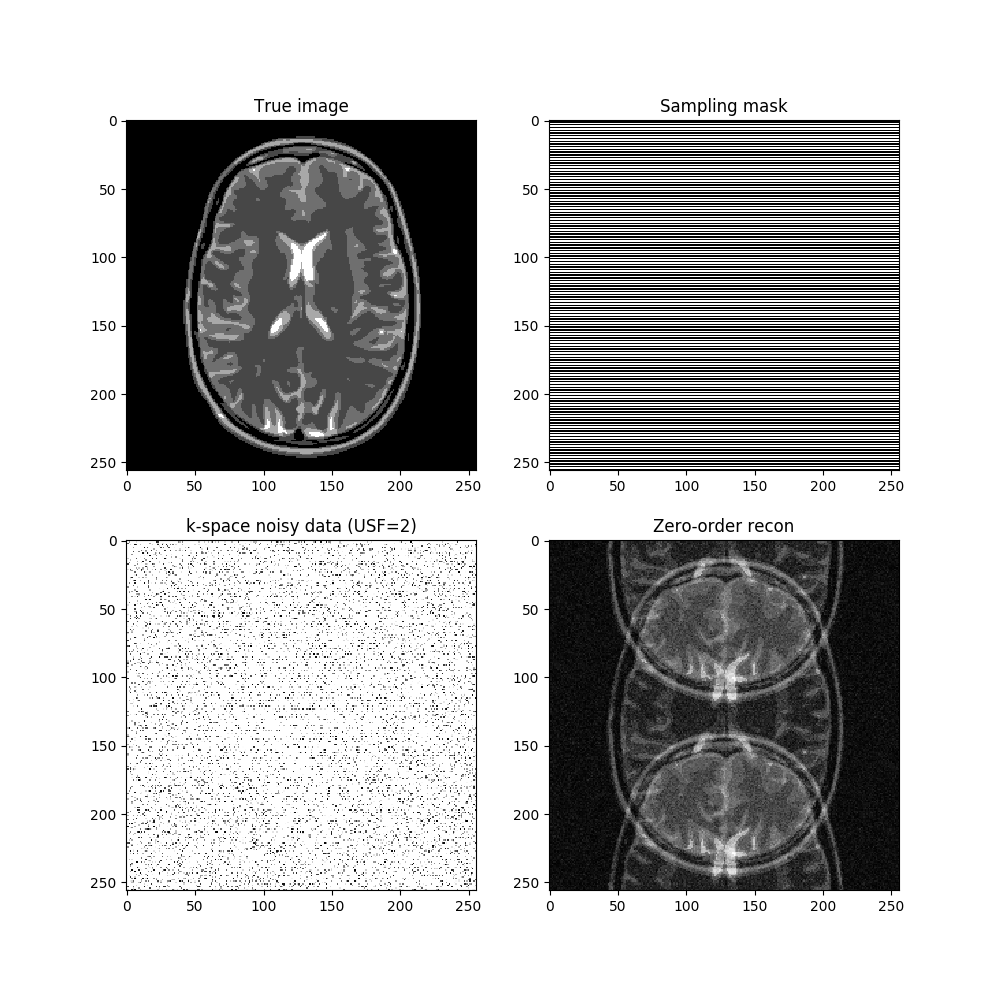

In [44]:
#import numpy.fft as fft
norm = "ortho"
#norm = None
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the subsampled kspace with R=2
kspace_data_r2 = np.fft.fftshift(fft(mri_img)) * kspace_mask_r2   # put the 0-freq in the middle of axes as

#noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data_r2 += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0_r2 = ifft(np.fft.ifftshift(kspace_data_r2))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask_r2, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data_r2),  cmap='gray', vmax=0.1*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (USF=2)")
axs[1,1].imshow(np.abs(image_rec0_r2), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()


<IPython.core.display.Javascript object>


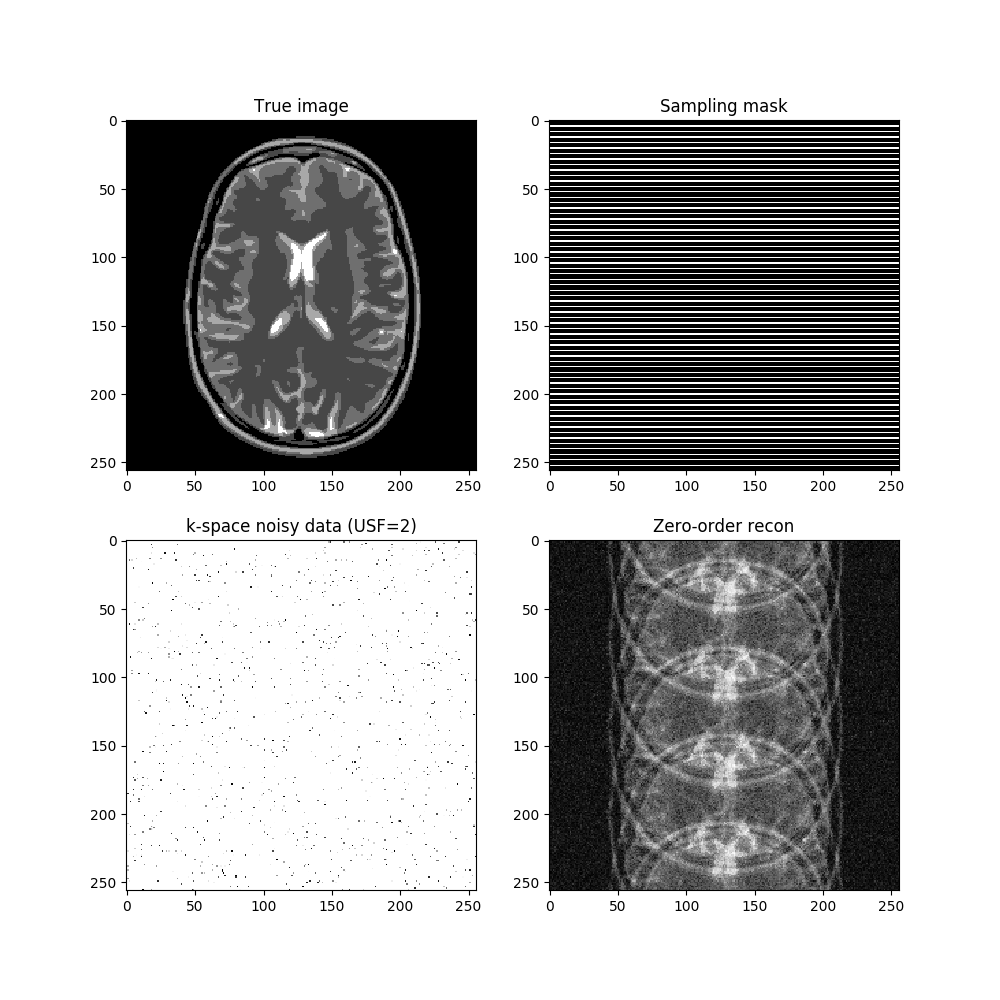

In [45]:
# Generate the subsampled kspace with R=4
kspace_data_r4 = np.fft.fftshift(fft(mri_img)) * kspace_mask_r4   # put the 0-freq in the middle of axes as
#noisy k-space data using Gaussian complex-valued random noise
signoise = 10
kspace_data_r4 += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Zero order solution
image_rec0_r4 = ifft(np.fft.ifftshift(kspace_data_r4))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask_r4, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data_r4),  cmap='gray', vmax=0.01*np.abs(kspace_data).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (USF=2)")
axs[1,1].imshow(np.abs(image_rec0_r4), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()
